In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import os.path as osp

# Set the number of (emulated) host devices
num_devices = 4
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={num_devices}"

import numpy as np

import jax
import jax.numpy as jnp
from jax import lax
import gymnax
from gymnax.visualize import Visualizer
from tqdm import tqdm

jax.device_count(), jax.devices()

(4, [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)])

In [3]:
from functools import partial

from utils.models import get_model_ready
from utils.helpers import load_config, save_pkl_object


from src.control.dynamics import cartpole_step,CartPoleEnvState,kinematics
from src.control.MPPI import MPPI_wrapper,weighting,MPPI_scores_wrapper,MPPI_control,weighting
from src.objective_fns.cost_to_go_fns import cart_pole_cost
from src.objective_fns.objectives import MPC_decorator

In [4]:
dynamic_rollout = jax.jit(partial(kinematics,step_fn=cartpole_step))

mppi = MPPI_wrapper(dynamic_rollout)

mpc_obj = MPC_decorator(cart_pole_cost,dynamic_rollout,0.99)

mppi_scores = MPPI_scores_wrapper(mpc_obj)

weight_fn = weighting()

In [5]:
class Args(object):
  def __init__(self):
    pass

args = Args()

args.num_traj = 350
args.horizon = 50
args.MPPI_iterations=75

episode_length = 400

In [6]:
random_key = jax.random.PRNGKey(123)

In [7]:
state = jnp.array([1.5,0.04,0.02,-0.05])

U = jnp.array(np.random.randn(15,args.horizon,1)*0.2)
U_nominal = U.mean(axis=0)

cov = jnp.eye(args.horizon)*10

In [8]:
state_seq_mppi = [CartPoleEnvState(t=0,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3])]
rewards = [cart_pole_cost(state)]

pbar = tqdm(total=episode_length, desc="Starting")

for i in range(episode_length):
  (U_nominal,cov_prime), (states,states_MPPI), cost_MPPI, key = MPPI_control(state,U_nominal,cov,random_key,
              dynamic_rollout,jnp.array([[-10,10]]),
              mppi,mppi_scores,weight_fn,
              method=None,state_train=None,
              args=args)
  
  state = states[0]
  rewards.append(cart_pole_cost(state))
  state_seq_mppi.append(CartPoleEnvState(t=i+1,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3]))

# print(U_nominal.shape)
# print("U: ",U_nominal)
  pbar.set_description(f"t: {i+1} State: {state} Action: {U_nominal[0]}")
  pbar.update(1)
  
pbar.close()

rewards = np.array(rewards)


t: 400 State: [-0.03235945 -0.00573138  0.00282819 -0.00286972] Action: [0.1174762]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.10it/s]


In [9]:
base =  osp.join("expert_agents","CartPole-v1","ppo")
configs = load_config(base + ".yaml")

In [10]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)

EnvParams(max_steps_in_episode=500, gravity=9.8, masscart=1.0, masspole=0.1, total_mass=1.1, length=0.5, polemass_length=0.05, force_mag=10.0, tau=0.02, theta_threshold_radians=0.20943951023931953, x_threshold=2.4)

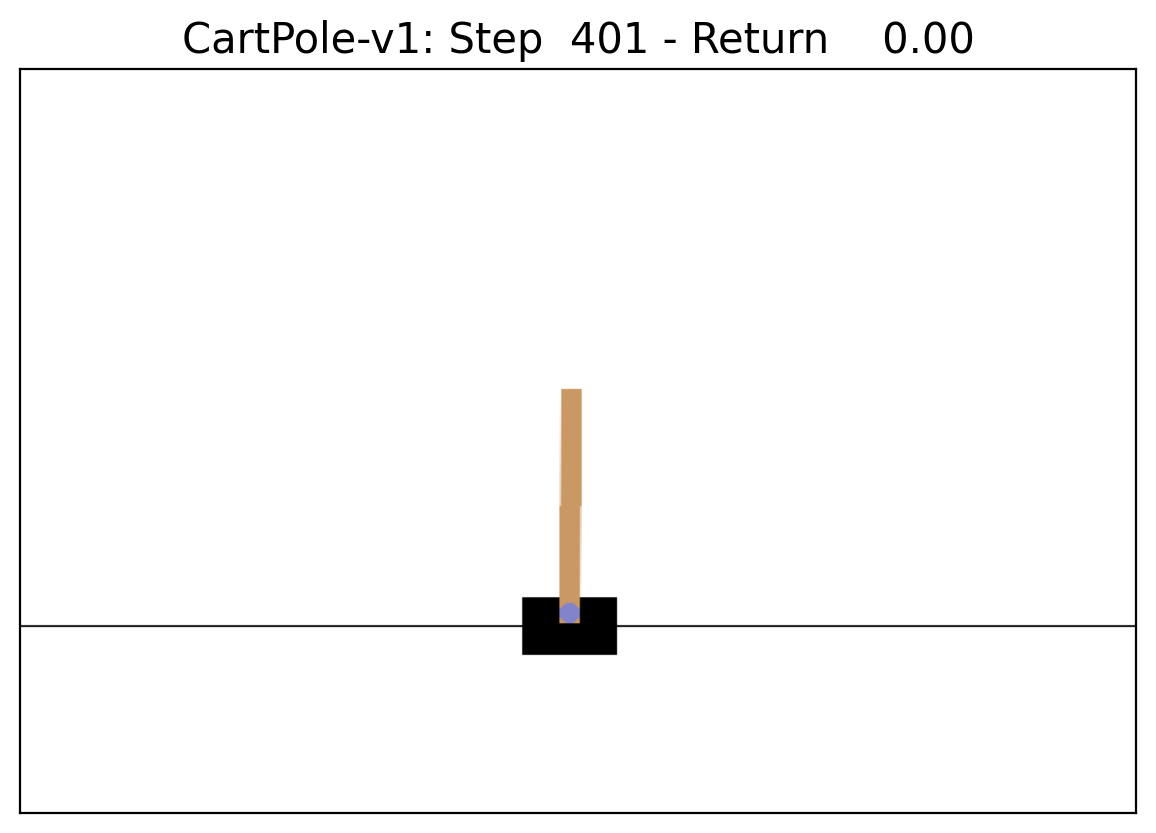

In [11]:
vis = Visualizer(env, env_params, state_seq_mppi, rewards)
vis.animate(osp.join("results","CartPole-v1-mppi.gif"))

## Random Action Demo

In [12]:
state = jnp.array([1.5,0.04,0.02,-0.05])

In [13]:
state_seq_random = [CartPoleEnvState(t=0,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3])]
rewards = [cart_pole_cost(state)]
for i in range(episode_length):
  action = jnp.array(np.random.randn(1,))*5
  action = jnp.clip(action,-10,10)

  
  state = cartpole_step(action,state)
  
  rewards.append(cart_pole_cost(state))
  state_seq_random.append(CartPoleEnvState(t=i+1,x=state[0],x_dot=state[1],theta=state[2],theta_dot=state[3]))

# print(U_nominal.shape)
# print("U: ",U_nominal)
  # print("State: ",state, "Action: ",action)

rewards = np.array(rewards)

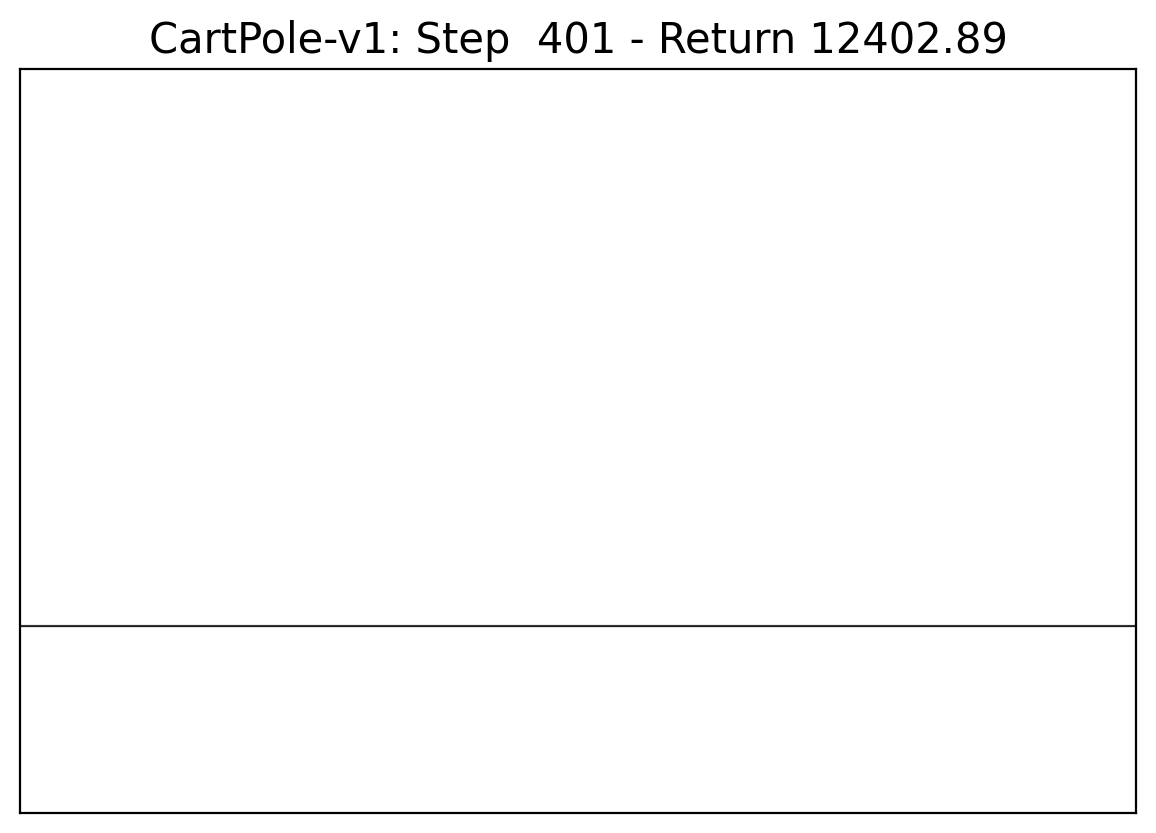

In [14]:
vis = Visualizer(env, env_params, state_seq_random,rewards)
vis.animate(osp.join("results","CartPole-v1-random.gif"))

## Expert Demo

In [15]:
from utils.models import load_neural_network

In [16]:
base =  osp.join("expert_agents","CartPole-v1","ppo")
configs = load_config(base + ".yaml")
model, model_params = load_neural_network(
    configs.train_config, base + ".pkl"
)



Loaded data from expert_agents\CartPole-v1\ppo.pkl.


In [17]:
from flax import struct
from gymnax.environments import EnvState

@struct.dataclass
class EnvState(EnvState):
    x: jnp.ndarray
    x_dot: jnp.ndarray
    theta: jnp.ndarray
    theta_dot: jnp.ndarray
    time: int

In [18]:
def rollout_episode(env, env_params, model, model_params, max_frames=200):
    state_seq = []
    rng = jax.random.PRNGKey(0)

    rng, rng_reset = jax.random.split(rng)
    # obs, env_state = env.reset(rng_reset, env_params)

    obs = jnp.array([0.8,0.04,0.02,-0.05])
    env_state = EnvState(
          x=obs[0],
          x_dot=obs[1],
          theta=obs[2],
          theta_dot=obs[3],
          time=0,
      )
  
    if model is not None:
        if model.model_name == "LSTM":
            hidden = model.initialize_carry()

    t_counter = 0
    reward_seq = []
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)

        v, pi = model.apply(model_params, obs, rng_act)

        action = pi.sample(seed=rng_act)

        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state, action, env_params
        )
      
        reward_seq.append(reward)
        print(t_counter, reward, action, done)
        print(10 * "=")
        t_counter += 1
        if done or t_counter == max_frames:
            break
        else:
            env_state = next_env_state
            obs = next_obs
    print(f"{env.name} - Steps: {t_counter}, Return: {np.sum(reward_seq)}")
    return state_seq, np.cumsum(reward_seq)

In [19]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)
state_seq, cum_rewards = rollout_episode(
    env, env_params, model, model_params,max_frames=episode_length
)

0 1.0 1 False
1 1.0 1 False
2 1.0 0 False
3 1.0 1 False
4 1.0 1 False
5 1.0 1 False
6 1.0 1 False
7 1.0 0 False
8 1.0 0 False
9 1.0 0 False
10 1.0 0 False
11 1.0 1 False
12 1.0 0 False
13 1.0 0 False
14 1.0 0 False
15 1.0 0 False
16 1.0 0 False
17 1.0 1 False
18 1.0 0 False
19 1.0 0 False
20 1.0 0 False
21 1.0 1 False
22 1.0 0 False
23 1.0 1 False
24 1.0 1 False
25 1.0 0 False
26 1.0 0 False
27 1.0 0 False
28 1.0 1 False
29 1.0 0 False
30 1.0 1 False
31 1.0 0 False
32 1.0 1 False
33 1.0 0 False
34 1.0 1 False
35 1.0 0 False
36 1.0 0 False
37 1.0 1 False
38 1.0 1 False
39 1.0 0 False
40 1.0 0 False
41 1.0 1 False
42 1.0 0 False
43 1.0 1 False
44 1.0 0 False
45 1.0 1 False
46 1.0 0 False
47 1.0 1 False
48 1.0 0 False
49 1.0 1 False
50 1.0 0 False
51 1.0 1 False
52 1.0 0 False
53 1.0 1 False
54 1.0 0 False
55 1.0 1 False
56 1.0 1 False
57 1.0 0 False
58 1.0 0 False
59 1.0 1 False
60 1.0 1 False
61 1.0 1 False
62 1.0 0 False
63 1.0 1 False
64 1.0 0 False
65 1.0 1 False
66 1.0 0 False
67 1.

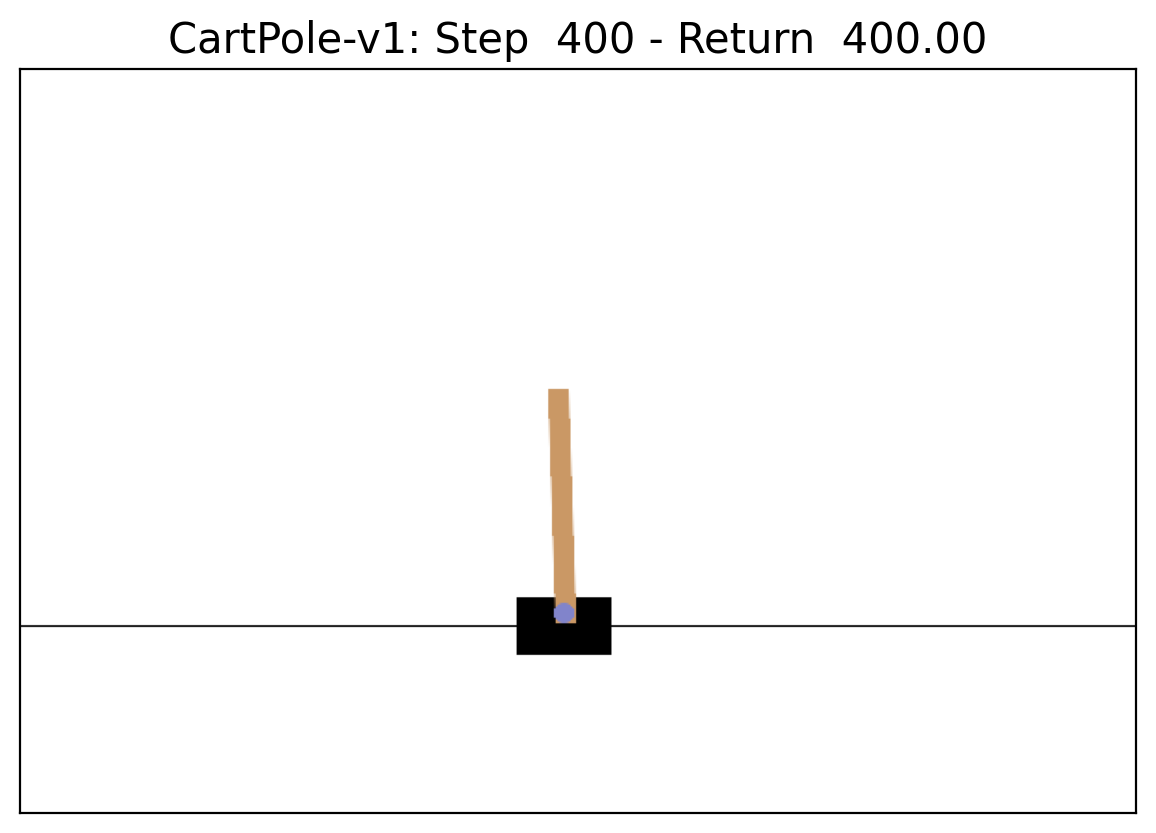

In [20]:
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate(osp.join("results","CartPole-v1.gif"))

# Debugging

In [21]:
"""Run training with ES or PPO. Store logs and agent ckpt."""
ppo_yaml = osp.join("expert_agents","CartPole-v1","ppo.yaml")
seed_id = 123
lrate = 5e-04

config = load_config(ppo_yaml, seed_id, lrate)

rng = jax.random.PRNGKey(config.train_config.seed_id)
# Setup the model architecture
rng, rng_init = jax.random.split(rng)
model, policy_params = get_model_ready(rng_init, config.train_config)

In [22]:
def batch_step(action, state):
    return jax.vmap(cartpole_step, in_axes=(0,0))(
        action, state)
    

In [23]:
state = jnp.array([0.1,0.1,0.1,0.1])
action = jnp.array([-1.])

In [24]:
state = cartpole_step(action,state)
state

Array([0.102     , 0.07907943, 0.102     , 0.1605751 ], dtype=float64)

In [25]:
state_batch = [jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,))]
state_batch = jnp.stack(state_batch,axis=1)
action_batch = jnp.array(np.random.randint(0,2,5)).astype(float).reshape(-1,1)

In [26]:
next_state  = batch_step(
   action_batch,state_batch
)
next_state

Array([[ 1.09086442,  1.35815675,  1.05208592,  0.52629729],
       [ 0.20863767, -2.15583116, -0.00657002, -0.508353  ],
       [ 1.53048853,  0.46790177, -1.19291221, -1.46998722],
       [ 0.10027936,  0.86445599, -1.24564495,  0.48072207],
       [-1.45253612, -0.58563416,  2.3246482 ,  0.5657961 ]],      dtype=float64)

In [27]:
state_batch = [jnp.ones(5),
                       jnp.ones(5),
                       jnp.ones(5),
                       jnp.ones(5)]
state_batch = jnp.stack(state_batch,axis=1)
action_batch = jnp.ones(5).reshape(-1,1)*-5

In [28]:
next_state  = batch_step(
   action_batch,state_batch
)

In [29]:
next_state

Array([[1.02      , 0.90182606, 1.02      , 1.32695788],
       [1.02      , 0.90182606, 1.02      , 1.32695788],
       [1.02      , 0.90182606, 1.02      , 1.32695788],
       [1.02      , 0.90182606, 1.02      , 1.32695788],
       [1.02      , 0.90182606, 1.02      , 1.32695788]], dtype=float64)

In [30]:
# Jit-Compiled Episode Rollout
from functools import partial

jit_rollout = jax.jit(partial(kinematics,step_fn=cartpole_step))

In [31]:
state = jnp.ones(4)*0.1
action = jnp.array(np.random.randint(0,2,10)).reshape(-1,1)
action.ravel()

Array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int32)

In [32]:
x_rollout = jit_rollout(action,state)

In [33]:
x_rollout

Array([[0.102     , 0.09857741, 0.102     , 0.13147425],
       [0.10397155, 0.09712752, 0.10462949, 0.16357381],
       [0.1059141 , 0.09564182, 0.10790096, 0.19649515],
       [0.10782693, 0.0941117 , 0.11183086, 0.23043834],
       [0.10970917, 0.11202287, 0.11643963, 0.23654919],
       [0.11194963, 0.12986893, 0.12117061, 0.24411732],
       [0.114547  , 0.14764834, 0.12605296, 0.2531808 ],
       [0.11749997, 0.16535922, 0.13111658, 0.26378677],
       [0.12080716, 0.16351148, 0.13639231, 0.30497251],
       [0.12407739, 0.18108035, 0.14249176, 0.31883907]], dtype=float64)

In [34]:
state_t =  jnp.array([0.25,.1,0.2,0.3])
action = jnp.array([15])
for t in range(10):
  state_t = cartpole_step(action,state_t)
  print(state_t)

[0.252      0.29179308 0.206      0.0764538 ]
[ 0.25783586  0.48345797  0.20752908 -0.14482839]
[ 0.26750502  0.67509729  0.20463251 -0.36554284]
[ 0.28100697  0.86681298  0.19732165 -0.58737341]
[ 0.29834323  1.05870429  0.18557418 -0.81198811]
[ 0.31951731  1.25086552  0.16933442 -1.04103478]
[ 0.34453462  1.44338324  0.14851373 -1.27613428]
[ 0.37340229  1.63633244  0.12299104 -1.51886944]
[ 0.40612894  1.82977135  0.09261365 -1.7707677 ]
[ 0.44272436  2.02373419  0.0571983  -2.0332756 ]


In [35]:
state = jnp.array([0.25,.1,0.2,0.3])
action = jnp.ones(10).reshape(-1,1)*15
x_rollout = jit_rollout(action,state)
x_rollout

Array([[ 0.252     ,  0.29179308,  0.206     ,  0.0764538 ],
       [ 0.25783586,  0.48345797,  0.20752908, -0.14482839],
       [ 0.26750502,  0.67509729,  0.20463251, -0.36554284],
       [ 0.28100697,  0.86681298,  0.19732165, -0.58737341],
       [ 0.29834323,  1.05870429,  0.18557418, -0.81198811],
       [ 0.31951731,  1.25086552,  0.16933442, -1.04103478],
       [ 0.34453462,  1.44338324,  0.14851373, -1.27613428],
       [ 0.37340229,  1.63633244,  0.12299104, -1.51886944],
       [ 0.40612894,  1.82977135,  0.09261365, -1.7707677 ],
       [ 0.44272436,  2.02373419,  0.0571983 , -2.0332756 ]],      dtype=float64)

In [36]:
cartpole_dynamics = jax.vmap(jit_rollout,in_axes=(0,None))

action = jnp.ones((10,5,1))*15

cartpole_dynamics(action,state)

Array([[[ 0.252     ,  0.29179308,  0.206     ,  0.0764538 ],
        [ 0.25783586,  0.48345797,  0.20752908, -0.14482839],
        [ 0.26750502,  0.67509729,  0.20463251, -0.36554284],
        [ 0.28100697,  0.86681298,  0.19732165, -0.58737341],
        [ 0.29834323,  1.05870429,  0.18557418, -0.81198811]],

       [[ 0.252     ,  0.29179308,  0.206     ,  0.0764538 ],
        [ 0.25783586,  0.48345797,  0.20752908, -0.14482839],
        [ 0.26750502,  0.67509729,  0.20463251, -0.36554284],
        [ 0.28100697,  0.86681298,  0.19732165, -0.58737341],
        [ 0.29834323,  1.05870429,  0.18557418, -0.81198811]],

       [[ 0.252     ,  0.29179308,  0.206     ,  0.0764538 ],
        [ 0.25783586,  0.48345797,  0.20752908, -0.14482839],
        [ 0.26750502,  0.67509729,  0.20463251, -0.36554284],
        [ 0.28100697,  0.86681298,  0.19732165, -0.58737341],
        [ 0.29834323,  1.05870429,  0.18557418, -0.81198811]],

       [[ 0.252     ,  0.29179308,  0.206     ,  0.0764538 ],
  